 ### DATASET FROM 
<http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import pandas as pd

from matplotlib import patches
from PIL import Image

In [2]:
# NWPU-RESISC45 Air Plane Dataset
ROOT_DIR = os.path.abspath('../')
print(ROOT_DIR)
DATA_ROOT = os.path.join(ROOT_DIR, 'data/air_planes')
ANN_DIR = os.path.join(DATA_ROOT, 'annotations/')
IMG_DIR = os.path.join(DATA_ROOT, 'images')

/home/jhjung/deeplearning_research/object_detection/RCNN


In [3]:
def DrawImage(img_files, gt_bboxes = [], cols=5, rows= 5):
    fig = plt.figure(figsize=(10, 10))

    for i, img_file in enumerate(img_files):
        ax = plt.subplot(rows, cols,i+1)
        
        if len(gt_bboxes) != 0:
            for bbox in gt_bboxes[i]:
                x1, y1, x2, y2 = bbox
                p = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, alpha=1.0, linestyle="solid", edgecolor='blue', facecolor='none')
                ax.add_patch(p)
            
        img = Image.open(os.path.join(img_path, img_file))
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()


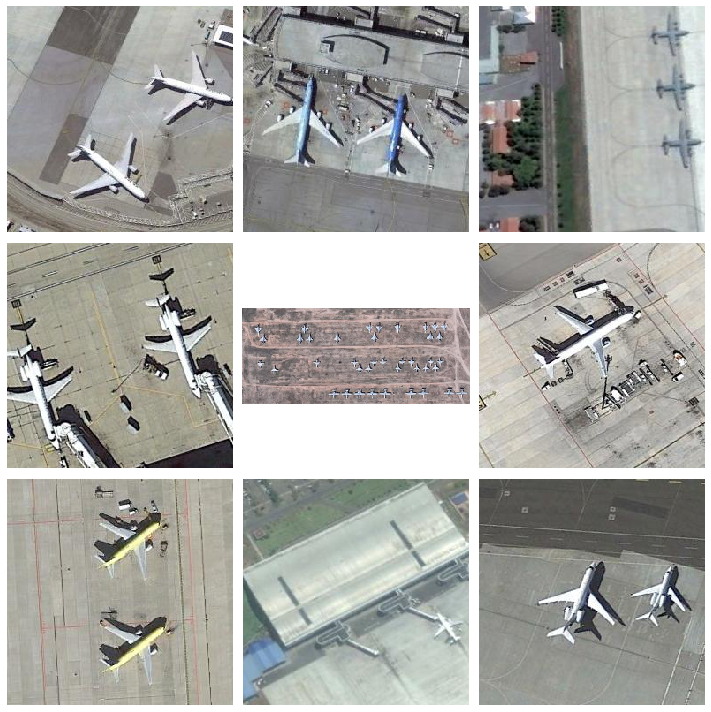

In [4]:
# Display Sample Images
img_path = os.path.join(DATA_ROOT, IMG_DIR)
img_list = os.listdir(img_path)
img_files = random.sample(img_list, 9)
DrawImage(img_files, cols=3, rows=3)

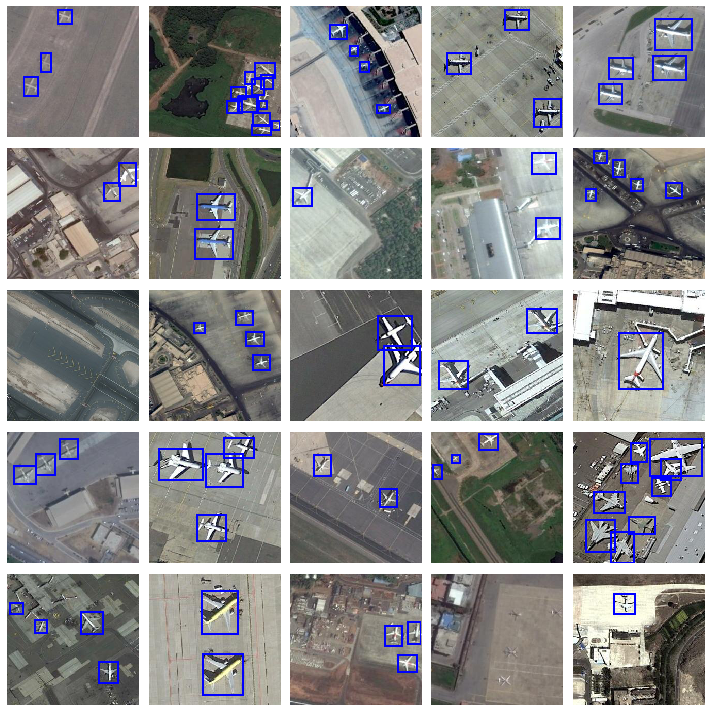

In [5]:
# Parsing Ground Truth Bounding Box
ann_list = os.listdir(ANN_DIR)
ann_files = random.sample(ann_list, 25)

gt_bboxes = []
img_files = []

for ann_file in ann_files:
    data = pd.read_csv(os.path.join(ANN_DIR, ann_file))
    gt_bbox = np.array([], dtype=np.int32).reshape(0, 4)

    for row in data.iterrows():
        line = row[1][0].split(" ")
        x1 = int(line[0])
        y1 = int(line[1])
        x2 = int(line[2])
        y2 = int(line[3])
        gt_bbox = np.vstack([gt_bbox, [x1, y1, x2, y2]])
    gt_bboxes.append(gt_bbox)
    img_files.append('{}.jpg'.format(os.path.splitext(ann_file)[0]))

DrawImage(img_files, gt_bboxes)

In [6]:
def DrawBoxes(img, bboxes, title='Empty', color='magenta', linestyle="solid", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
    
    # BBox Display
    # Box 좌표 구성(xmin, ymin, xmax, ymax)
    for bbox in bboxes:
        p = patches.Rectangle((bbox[0], bbox[1]), (bbox[2]-bbox[0]), (bbox[3]-bbox[1]), linewidth=2, alpha=1.0, linestyle=linestyle, edgecolor=color, facecolor='none')
        ax.add_patch(p)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(title)

In [7]:
def ComputeIOU(gt, p):

    x1 = np.maximum(gt[0], p[:, 0])
    y1 = np.maximum(gt[1], p[:, 1])
    x2 = np.minimum(gt[2], p[:, 2])
    y2 = np.minimum(gt[3], p[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    propoesed_area = (p[:, 2] - p[:, 0]) * (p[:, 3] - p[:, 1])
    union = gt_area + propoesed_area[:] - intersection[:]

    iou = intersection/union
    
    return iou

In [8]:
def ComputeTargetDelta(gt, p):
    d = np.zeros_like(p, dtype=np.float32)
    gt = gt.astype(np.float32)
    p = p.astype(np.float32)

    d[:, 0] = np.divide(np.subtract(gt[0], p[:,0]), p[:,2])
    d[:, 1] = np.divide(np.subtract(gt[1], p[:,1]), p[:,3])
    d[:, 2] = np.log(np.divide(gt[2], p[:,2]))
    d[:, 3] = np.log(np.divide(gt[2], p[:,3]))
    
    return d

In [9]:
def AdjustRegion(gt_bboxes, roi):
    POS_LB = 1
    NEG_LB = 0
    MAX_COUNT = 30
    regions = np.array([], dtype=np.int32).reshape(0, 5)
    delta = np.array([], dtype=np.float32).reshape(0, 4)
    
    for bbox in gt_bboxes:
        iou_results = ComputeIOU(bbox, roi)
        # selective search로 얻은 region은 최대 2000개 까지만 사용
        iou_results = iou_results[:2000]

        # i'th GT BBox와 IOU가 0.5 이상인 경우 Positive(최대 영역 갯수 30개)
        if len(regions[np.where(regions[:,0] == POS_LB)]) < MAX_COUNT:
            temp_pos = roi[np.where(iou_results >= 0.5)]

            if len(temp_pos) > MAX_COUNT:
                temp_pos = temp_pos[:MAX_COUNT]
                
            # Positive 영역과 GT간의 Delta값 계산
            delta = np.vstack([delta, ComputeTargetDelta(bbox, temp_pos)])
            
            # 0번째 index에 positive label insert
            pos = np.insert(temp_pos, 4, POS_LB, axis=1)
            regions = np.vstack([regions, pos])

        # i'th GT BBox와 IOU가 0.5 이상인 경우 Negative(최대 영역 갯수 30개)
        if len(regions[np.where(regions[:,0] == NEG_LB)]) < MAX_COUNT:
            temp_neg = roi[np.where(iou_results <= 0.3)]
            if len(temp_neg) > MAX_COUNT:
                temp_neg = temp_neg[:MAX_COUNT]
            
            # 0번째 index에 negative label insert
            temp_neg = np.insert(temp_neg, 4, NEG_LB, axis=1)
            regions = np.vstack([regions, temp_neg])
          
    return regions, delta

In [10]:
def NewAdjustRegions(gt_bbox, rois):
    regions = np.array([], dtype=np.float32).reshape(0, 5)
    deltas = np.array([], dtype=np.float32).reshape(0, 4)

    pos_candidate = np.array([], dtype=np.float32).reshape(0, 5)
    rois_copy = rois.copy()

    for gt in gt_bbox:
        sub_regions = np.array([], dtype=np.float32).reshape(0, 5)

        iou = ComputeIOU(gt, rois_copy)

        # ADD Candidate Positive Regions(IOU > 0.5)
        idx = np.where(iou > 0.5)[0]
        print(idx)
        sub_regions = np.vstack([sub_regions, np.column_stack([rois_copy[idx], iou[idx]])])
        rois_copy = np.delete(rois_copy, idx, axis=0)

        # ADD GT
        gt = np.insert(gt, 4, 1.0)
        sub_regions = np.vstack([sub_regions, gt])
        sub_delta = ComputeTargetDelta(gt, sub_regions)

        deltas = np.vstack([deltas, np.delete(sub_delta, 4, axis=1)])
        pos_candidate = np.vstack([pos_candidate, sub_regions])

    # Positive Regions Sort(Descending)
    print(pos_candidate.shape)
    print(deltas.shape)

    sort_dix = np.argsort(-pos_candidate[:, 4])
    pos_candidate = pos_candidate[sort_dix][:32]
    pos_candidate = np.delete(pos_candidate, 4, axis=1)
    deltas = deltas[:32]

    # ADD Positive Regions
    regions = np.vstack([regions, np.insert(pos_candidate[:], 4, 1, axis = 1)])

    # ADD Negative Regions
    neg_idx = random.sample(range(rois_copy.shape[0]), 96)
    regions = np.vstack([regions, np.insert(rois_copy[neg_idx], 4, 0, axis = 1)])
    
    return regions, deltas


Proposed Region :: 726
gt_bbox:: [[ 86 109 144 156]
 [ 68 156 127 199]
 [ 80   6 175  68]
 [ 28  57  84  97]
 [  5 100  47 139]]


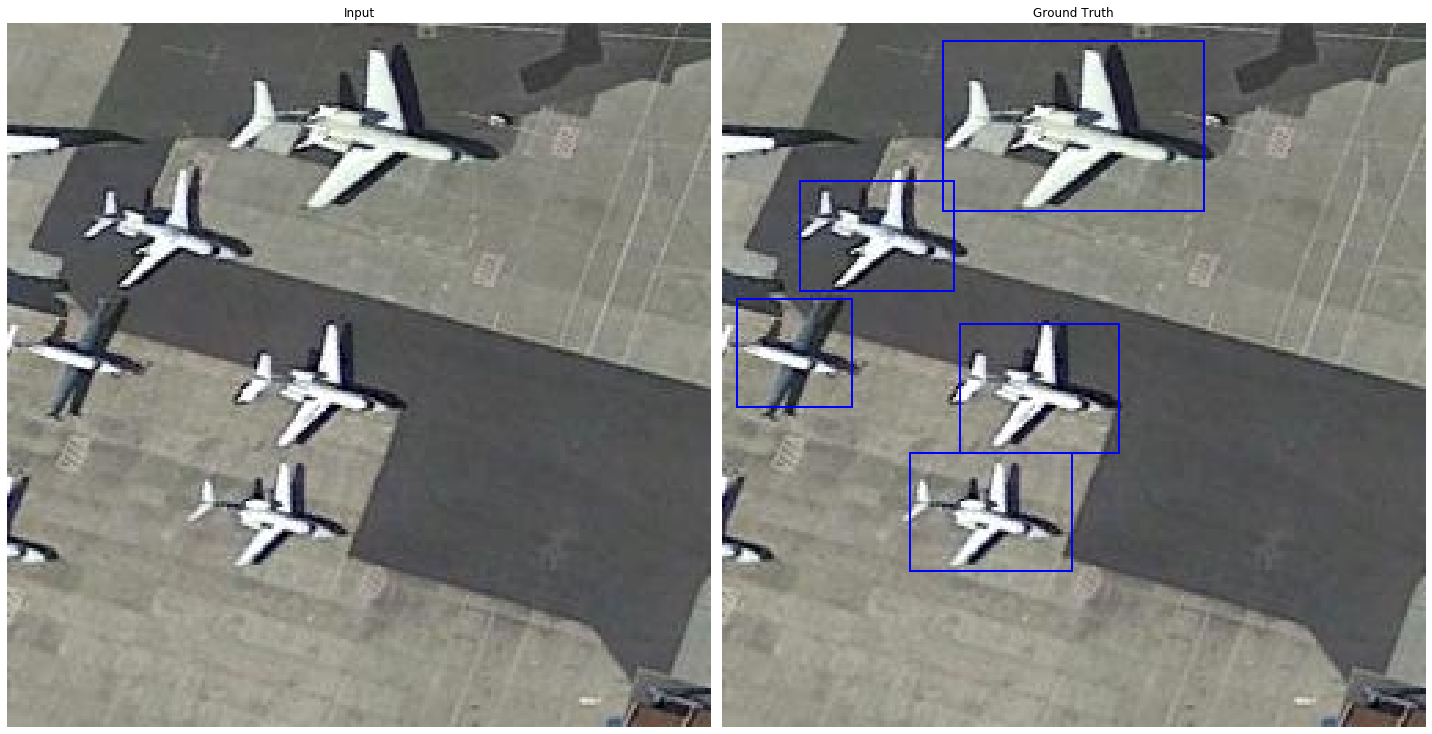

In [11]:
test_img_list = np.load(os.path.join(ROOT_DIR, 'experiments/test_img_list.npy'))
# img_id = 5

# img_file = random.choice(test_img_list)
# img_file = test_img_list[img_id]
img_file = 'airplane_190.jpg'

img = cv2.imread(os.path.join(IMG_DIR, img_file))

# Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rois = ss.process()
print('Proposed Region :: {}'.format(len(rois)))

rois[:, 2] = rois[:, 0] + rois[:, 2]
rois[:, 3] = rois[:, 1] + rois[:, 3]

ann_file = '{}.csv'.format(img_file.split('.')[0])
data = pd.read_csv(os.path.join(ANN_DIR, ann_file))
gt_bbox = np.array([], dtype=np.int32).reshape(0, 4)

for row in data.iterrows():
    line = row[1][0].split(" ")
    x1 = int(line[0])
    y1 = int(line[1])
    x2 = int(line[2])
    y2 = int(line[3])
    gt_bbox = np.vstack([gt_bbox, [x1, y1, x2, y2]])

print('gt_bbox::',gt_bbox)
regions, delta = AdjustRegion(gt_bbox, rois)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
DrawBoxes(img, [], title='Input', color='blue', linestyle="-", ax=ax[0])
DrawBoxes(img, gt_bbox, title='Ground Truth', color='blue', linestyle="-", ax=ax[1])
plt.tight_layout()

pos regions shape :: (80, 5)
neg regions shape :: (90, 5)


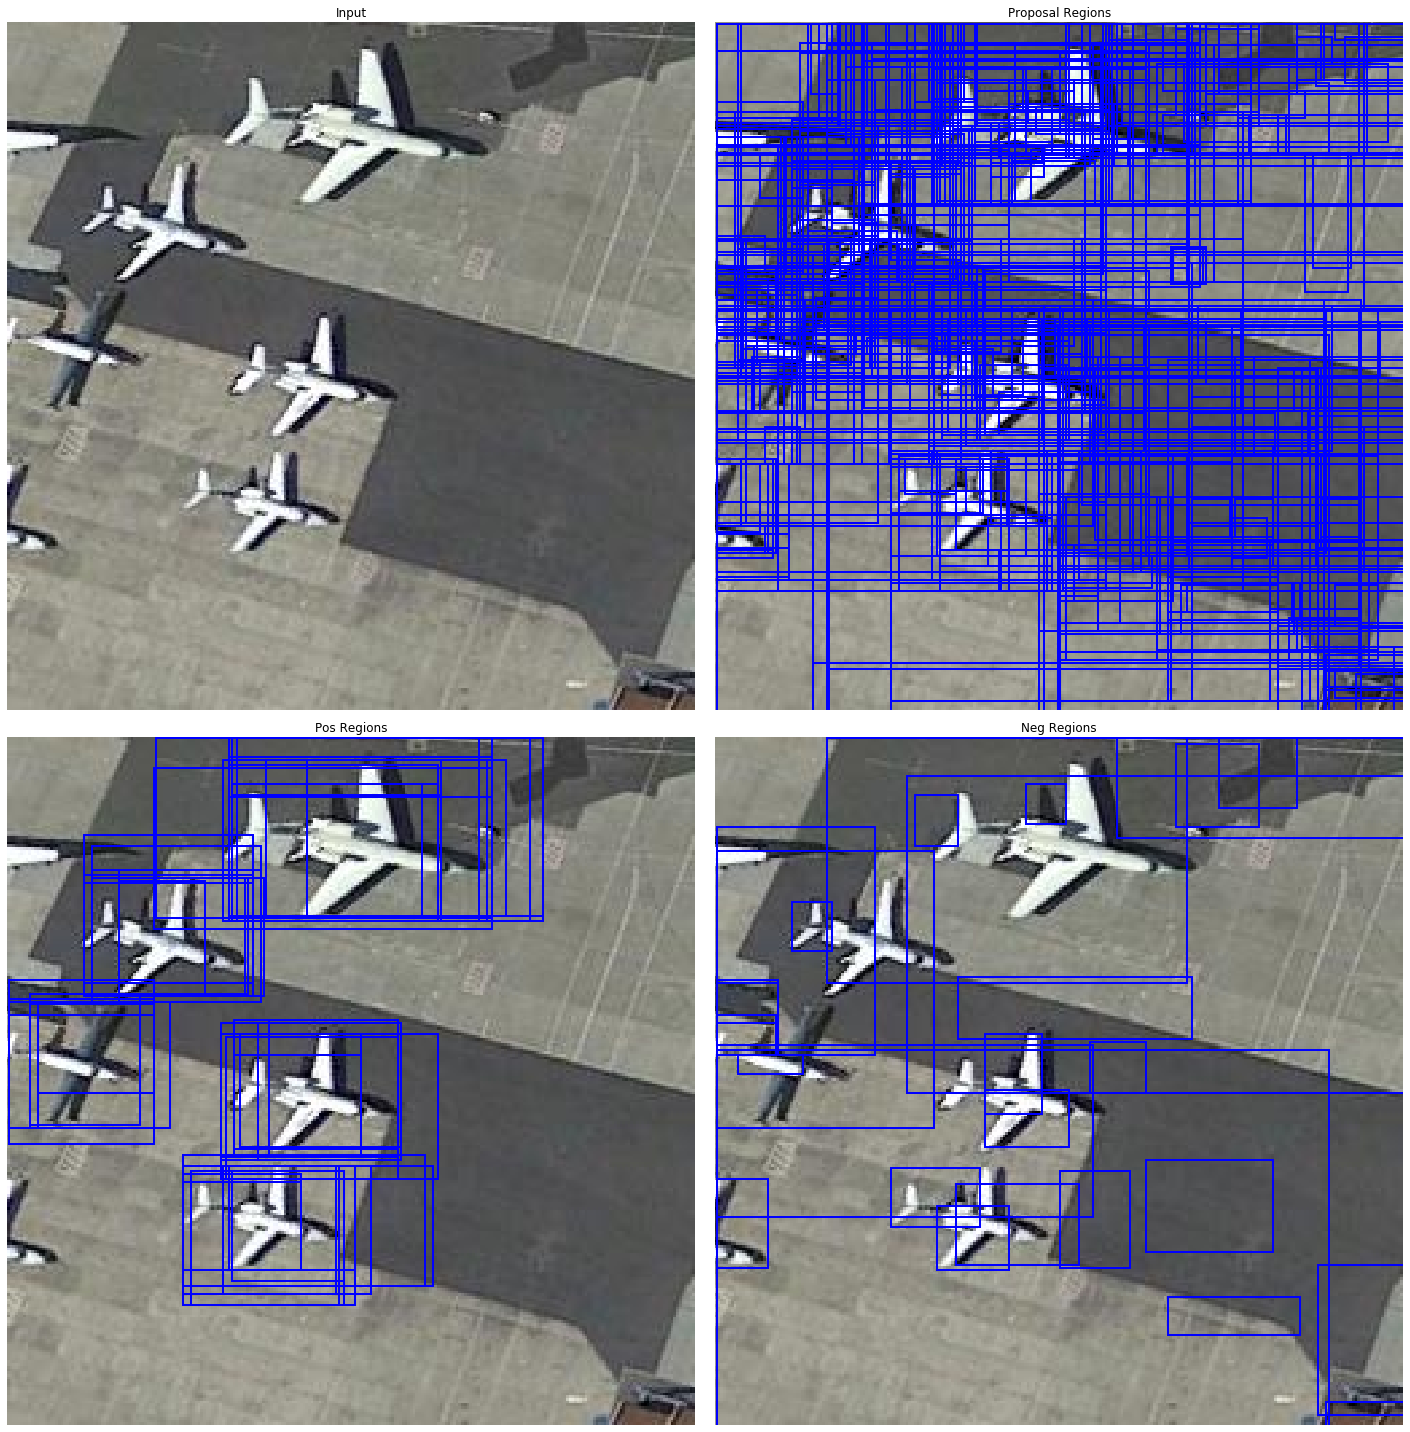

In [12]:
# Before Adjust Regions
regions, delta = AdjustRegion(gt_bbox, rois)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
DrawBoxes(img, [], title='Input', color='blue', linestyle="-", ax=ax[0][0])
DrawBoxes(img, rois, title='Proposal Regions', color='blue', linestyle="-", ax=ax[0][1])
DrawBoxes(img, regions[np.where(regions[:,4] == 1)], title='Pos Regions', color='blue', linestyle="-", ax=ax[1][0])
DrawBoxes(img, regions[np.where(regions[:,4] == 0)], title='Neg Regions', color='blue', linestyle="-", ax=ax[1][1])
plt.tight_layout()
print('pos regions shape ::', regions[np.where(regions[:,4]==1)[0]].shape)
print('neg regions shape ::', regions[np.where(regions[:,4]==0)[0]].shape)

[ 87 103 123 258 268 353 374 419 485 611 639 640]
[ 67 103 129 189 251 317 335 373 448 480 568 591 596 623 637]
[ 87  97 150 239 263 265 279 398 437 471 492 546 576 579 583 587 605 619
 622 635 639 648 652 655 665 673 674 690 692]
[ 38 168 207 262 361 438 445 454 475 502 513 542 577 599 612]
[ 93 346 359 403 494 562 571 576 591]
(85, 5)
(85, 4)
pos regions shape :: (32, 5)
neg regions shape :: (96, 5)


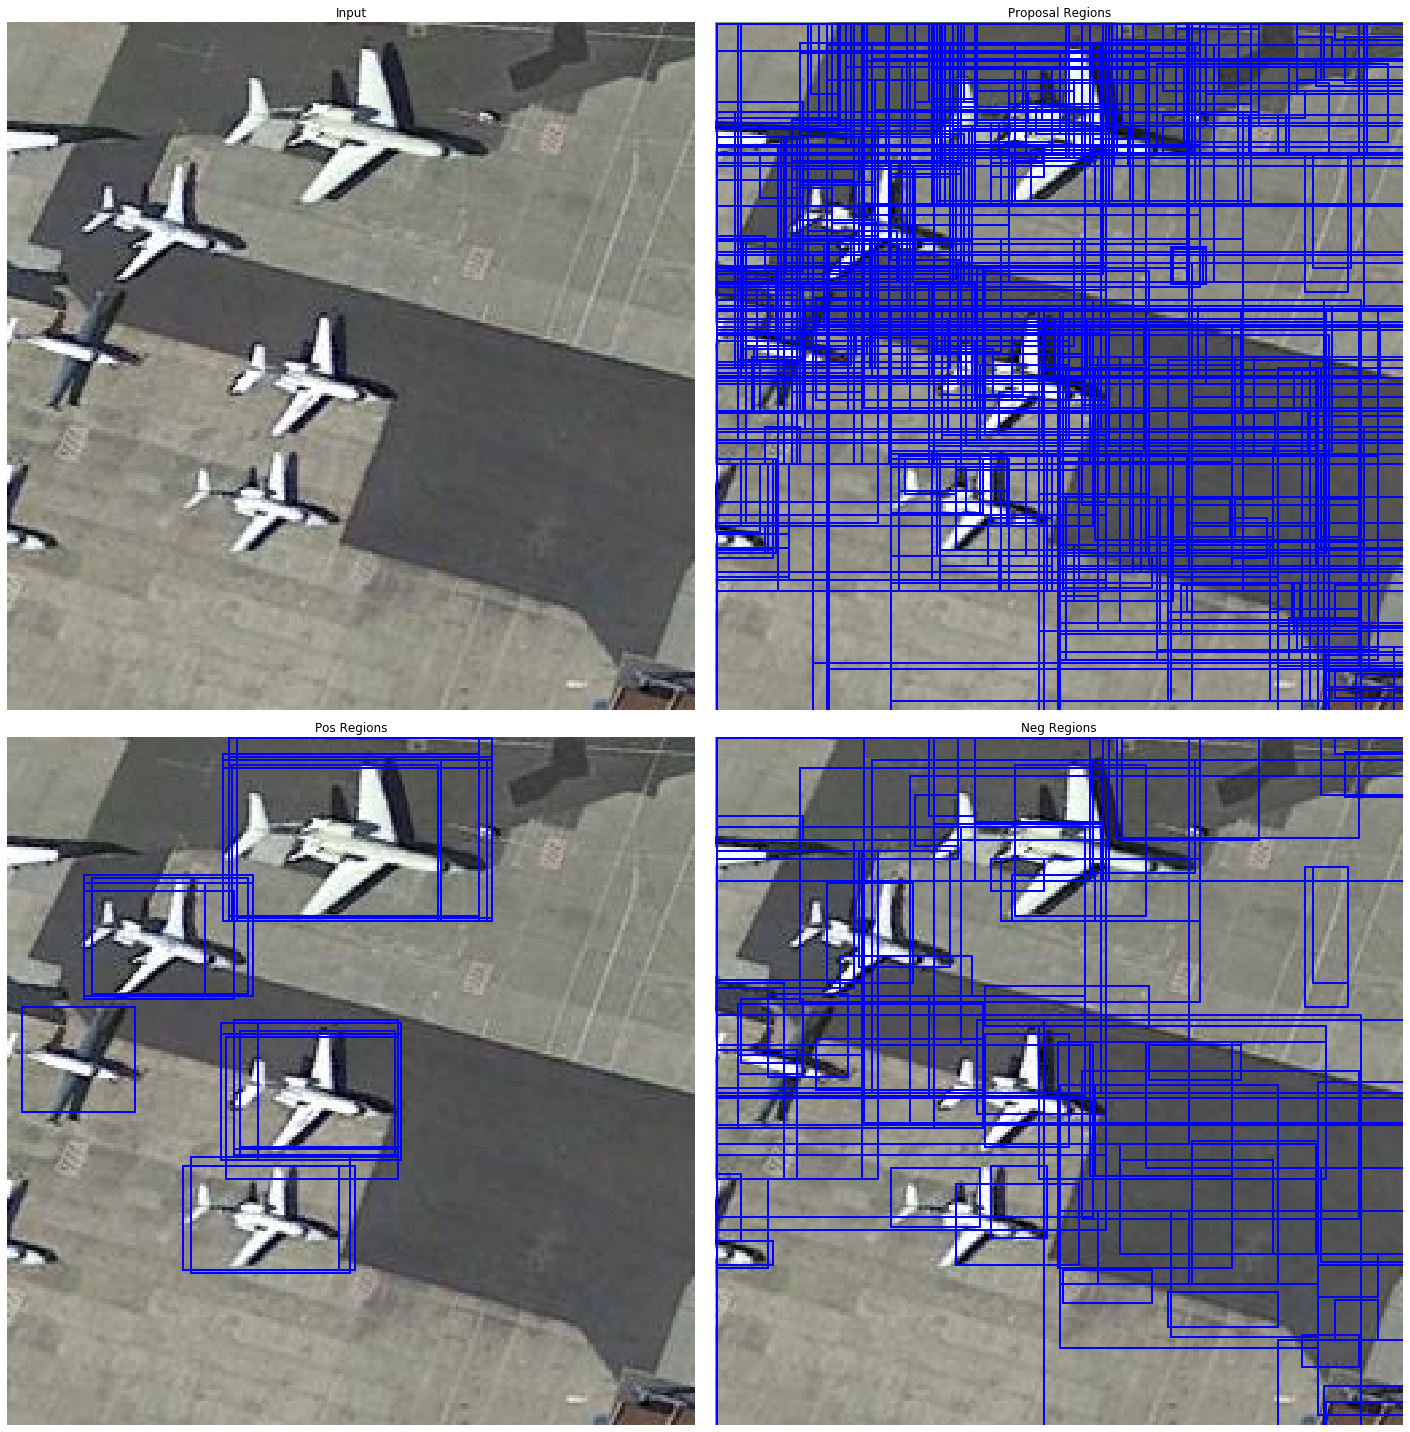

In [13]:
# New Adjust Regions
regions, delta = NewAdjustRegions(gt_bbox, rois)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
DrawBoxes(img, [], title='Input', color='blue', linestyle="-", ax=ax[0][0])
DrawBoxes(img, rois, title='Proposal Regions', color='blue', linestyle="-", ax=ax[0][1])
DrawBoxes(img, regions[np.where(regions[:,4] == 1)], title='Pos Regions', color='blue', linestyle="-", ax=ax[1][0])
DrawBoxes(img, regions[np.where(regions[:,4] == 0)], title='Neg Regions', color='blue', linestyle="-", ax=ax[1][1])
plt.tight_layout()
print('pos regions shape ::', regions[np.where(regions[:,4]==1)[0]].shape)
print('neg regions shape ::', regions[np.where(regions[:,4]==0)[0]].shape)